<a href="https://colab.research.google.com/github/scottSart/permit_project/blob/main/Loading_and_Understanding_2025-03-07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# loading libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
import requests
import zipfile
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Identifying data paths
dir = os.getcwd()

In [3]:
url = "https://www2.census.gov/econ/bps/Master%20Data%20Set/BPS_Compiled_File_202501.zip"
response = requests.get(url)
with open("BPS_Compiled_File_202412.zip", "wb") as file:
    file.write(response.content)

with zipfile.ZipFile("BPS_Compiled_File_202412.zip", "r") as z:
    csv_filename = z.namelist()[0]
    with z.open(csv_filename) as f:
        permit_data = pd.read_csv(f, encoding='latin1')


<ipython-input-3-82337f69dae3>:9: DtypeWarning: Columns (9,11,13,16,24,28,32,35,60) have mixed types. Specify dtype option on import or set low_memory=False.
  permit_data = pd.read_csv(f, encoding='latin1')


In [4]:
permit_data['ftype'] = permit_data['FILE_NAME'].str[:2]

permit_data['ftype'].value_counts()

,count
ftype,
mw,3322724
ne,2888635
so,2240166
we,1295495
co,750691
ma,325316
st,60748
cb,23946


In [5]:
# Identfying and filtering out relevant cols

cols = ['FILE_NAME','ftype','PLACE_NAME','SURVEY_DATE','NUMBER_OF_MONTHS_REP','PERIOD',
        'CBSA_CODE', 'CBSA_NAME','CENSUS_PLACE_CODE', 'CENTRAL_CITY',
        'COUNTY_CODE', 'COUNTY_NAME','CSA_CODE','STATE_NAME',
        'DIVISION_CODE', 'DIVISION_NAME','YEAR', 'ZIP_CODE',
        'LOCATION_NAME','TOTAL_UNITS','UNITS_1_UNIT','UNITS_2_UNITS',
        'VALUE_3_4_UNITS','UNITS_5_UNITS']

permit_data_red = permit_data[cols]


In [18]:
non_numeric_states = permit_data_red[pd.to_numeric(permit_data_red['STATE_NAME'], errors='coerce').isnull()]['STATE_NAME'].unique()

In [19]:
clean_permit = permit_data_red[permit_data_red['STATE_NAME'].isin(non_numeric_states)]

In [21]:
clean_permit['PERIOD'].value_counts()

# 	count PERIOD
# Year-to-date	4975667
# Monthly	4972374
# Annual	958307

,count
PERIOD,
Year-to-date,4975667
Monthly,4972374
Annual,958307


In [22]:
# seperating each type of data
permit_monthly = clean_permit[clean_permit['PERIOD'] == 'Monthly']
permit_annual = clean_permit[clean_permit['PERIOD'] == 'Annual']

In [23]:
# permit_monthly['PLACE_NAME'].isna().sum() ## 22,339 rows without 'place'
permit_data_before_2021 = clean_permit[clean_permit['YEAR']< 2021]

permit_data_before_2021['STATE_NAME'].value_counts().sort_index(ascending=True)

,count
STATE_NAME,
Alabama,105294
Alaska,39303
Arizona,56029
Arkansas,94231
California,382067
Colorado,108839
Connecticut,126686
Delaware,15886
District Of Columbia,2201


In [24]:
# filtering out rows without 'place'
permit_monthly_wo_place = permit_monthly[permit_monthly['PLACE_NAME'].isna()]
# permit_monthly_wo_place['ftype'].value_counts() # has county, metro and state information
permit_monthly_w_place = permit_monthly[permit_monthly['PLACE_NAME'].notna()]
# permit_monthly_w_place['ftype'].value_counts() # has south, west, north east, midwest bifurcation

In [26]:

# Testing to see the difference between w_place and wo_place

# Using LA County as an example:
# 1) Used 2022-12 and found perfect alignment between the two.
# 1.1) WO Place generated one row of data and W Place generated multiple rows of data; However, 'total permits' were aggregated by County and were equal to WO Place
# 2) Then, used 2006-12 and have been able to find alignment on second try

lax_w_place = permit_monthly_w_place[permit_monthly_w_place['COUNTY_NAME'] == 'Los Angeles County']
lax_2006_w_place = lax_w_place[lax_w_place['SURVEY_DATE'] == 200612]


lax_wo_place = permit_monthly_wo_place[permit_monthly_wo_place['COUNTY_NAME'] == 'Los Angeles County']
lax_2006_wo_place = lax_wo_place[lax_wo_place['SURVEY_DATE'] == 200612]

print(lax_2006_w_place['TOTAL_UNITS'].sum())
print(lax_2006_wo_place['TOTAL_UNITS'].sum()) # Both values match perfectly for 2006 too


2076
2076


In [27]:
# Understanding the W PLace File
primary_permit = permit_monthly_w_place.copy()
primary_permit = primary_permit[primary_permit['YEAR'] >= 2000]
primary_permit_2020before = primary_permit[primary_permit['YEAR']< 2021]

primary_permit_2020before['STATE_NAME'].nunique()

permit_monthly_wo_place_before_2021 = permit_monthly_wo_place[permit_monthly_wo_place['YEAR']< 2021]


In [28]:
# Markdown: Analyzing if permit_monthly_w_place is balanced across all time periods

### Before 2021

# Check the distribution of data across survey dates
survey_date_counts = primary_permit_2020before['SURVEY_DATE'].value_counts().sort_index()
print(f"Number of unique survey dates: {len(survey_date_counts)}")
print(f"Date range: {survey_date_counts.index.min()} to {survey_date_counts.index.max()}")

Number of unique survey dates: 252
Date range: 200001 to 202012


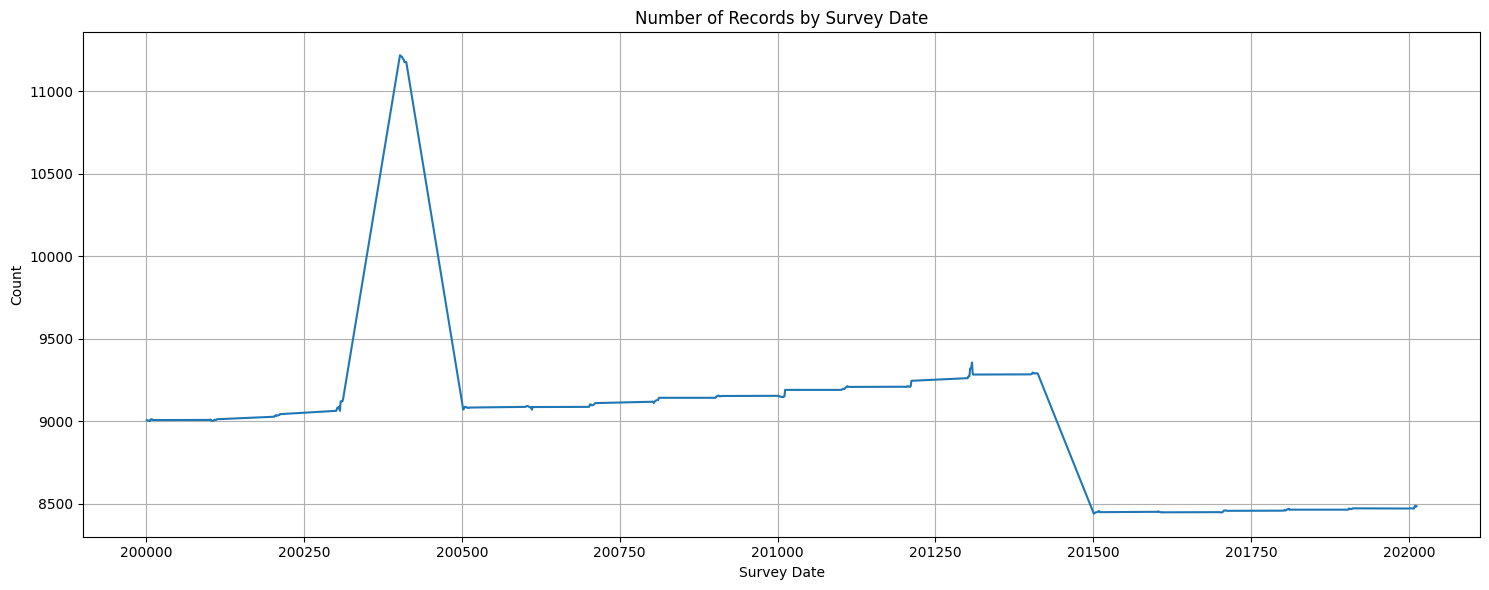

In [29]:
# Plot the distribution of records across time
plt.figure(figsize=(15, 6))
survey_date_counts.plot(kind='line')
plt.title('Number of Records by Survey Date')
plt.xlabel('Survey Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
#plt.savefig(os.path.join(initial_insights_dir, 'permit_monthly_w_place_distribution_before_2021.png'))
plt.show()


In [30]:
# Check if all counties have data for all time periods
county_date_matrix_before_2021 = primary_permit_2020before.groupby(['COUNTY_NAME', 'STATE_NAME', 'SURVEY_DATE']).size().unstack().reset_index() # 432 unique counties;
# Removing NAs gets us 276 counties
print(f"Shape of county-date matrix: {county_date_matrix_before_2021.shape}")
print(f"Number of counties: {len(county_date_matrix_before_2021)}")
print(f"Percentage of missing values: {(county_date_matrix_before_2021.isna().sum().sum() / county_date_matrix_before_2021.size) * 100:.2f}%")


Shape of county-date matrix: (2581, 254)
Number of counties: 2581
Percentage of missing values: 23.03%


In [31]:
### All
survey_date_counts = primary_permit['SURVEY_DATE'].value_counts().sort_index()
print(f"Number of unique survey dates: {len(survey_date_counts)}")
print(f"Date range: {survey_date_counts.index.min()} to {survey_date_counts.index.max()}")


Number of unique survey dates: 301
Date range: 200001 to 202501


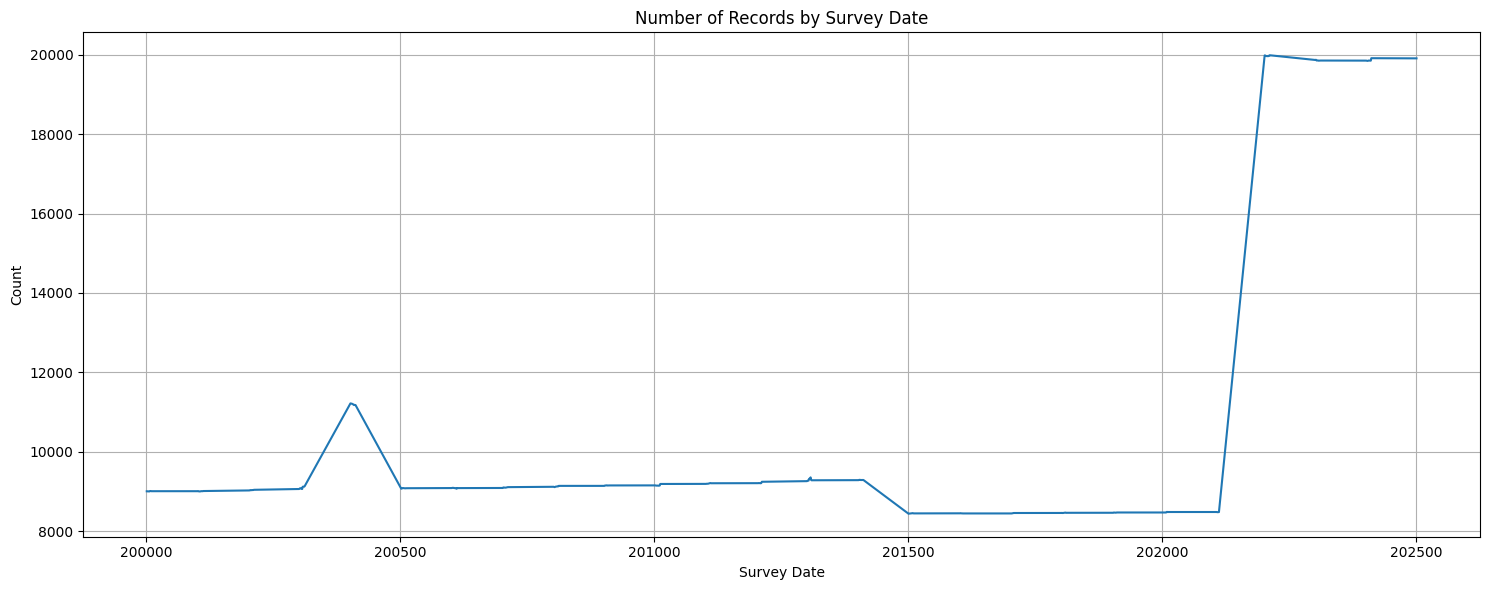

In [137]:
# Plot the distribution of records across time
plt.figure(figsize=(15, 6))
survey_date_counts.plot(kind='line')
plt.title('Number of Records by Survey Date')
plt.xlabel('Survey Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(initial_insights_dir, 'permit_monthly_w_place_distribution_all.png'))
plt.show()


# something happens in 2004, potentially indicating a change in data pooling process.

In [138]:
# Check if all counties have data for all time periods
county_date_matrix_all = primary_permit.groupby(['COUNTY_NAME', 'STATE_NAME', 'SURVEY_DATE']).size().unstack().reset_index()
print(f"Shape of county-date matrix: {county_date_matrix_all.shape}")
print(f"Number of counties: {len(county_date_matrix_all)}")
print(f"Percentage of missing values: {(county_date_matrix_all.isna().sum().sum() / county_date_matrix_all.size) * 100:.2f}%")


Shape of county-date matrix: (3072, 303)
Number of counties: 3072
Percentage of missing values: 31.26%


In [ ]:
print(county_date_matrix_all['STATE_NAME'].value_counts())
print(county_date_matrix_before_2021['STATE_NAME'].value_counts())

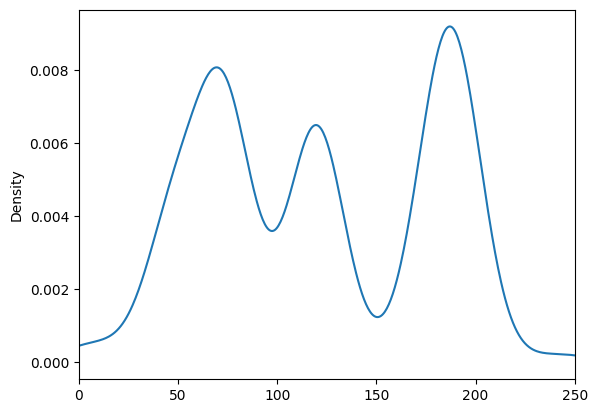

In [141]:
# Calculate the number of NaN values for each county-state combination
county_na_counts = county_date_matrix_before_2021.set_index(['COUNTY_NAME', 'STATE_NAME']).isna().sum(axis=1)

# Convert to DataFrame for better display
county_na_df = county_na_counts.reset_index()
county_na_df.columns = ['COUNTY_NAME', 'STATE_NAME', 'NA_COUNT']

# Filter out counties with zero NAs
county_na_df = county_na_df[county_na_df['NA_COUNT'] > 0]

# Sort from smallest to largest number of NAs
county_na_df_sorted = county_na_df.sort_values('NA_COUNT')

# Display the results
county_na_df_sorted['NA_COUNT'].plot(kind='density')
plt.xlim(0, 250)
# plt.savefig(os.path.join(initial_insights_dir, 'missingness_before_2021.png'))
plt.show()


In [142]:
balanced_counties = county_date_matrix_before_2021.dropna()

# Creating a list of counties with complete data before 2021
complete_counties = balanced_counties[['COUNTY_NAME', 'STATE_NAME']].drop_duplicates()

# Display information about complete counties
print(f"Number of counties with complete data before 2021: {len(complete_counties)}")


Number of counties with complete data before 2021: 1332


In [143]:
# Create a filtered version of primary_permit containing only the counties with complete data
filtered_permit = primary_permit.merge(
    complete_counties,
    on=['COUNTY_NAME', 'STATE_NAME'],
    how='inner'
)

# Count unique county names
print(f"Number of unique county names: {filtered_permit[['COUNTY_NAME','STATE_NAME']].nunique()}")
print(f"Number of unique county names: {primary_permit[['COUNTY_NAME','STATE_NAME']].nunique()}")
print(f"Number of unique county names: {complete_counties[['COUNTY_NAME','STATE_NAME']].nunique()}")


Number of unique county names: COUNTY_NAME    959
STATE_NAME      51
dtype: int64
Number of unique county names: COUNTY_NAME    1842
STATE_NAME       51
dtype: int64
Number of unique county names: SURVEY_DATE
COUNTY_NAME    959
STATE_NAME      51
dtype: int64


In [144]:
# Display information about the filtered dataset
print(f"Original primary_permit shape: {primary_permit.shape}")
print(f"Filtered primary_permit shape: {filtered_permit.shape}")
print(f"Percentage of data retained: {(filtered_permit.shape[0] / primary_permit.shape[0]) * 100:.2f}%")

# Save the filtered dataset
balanced_matrix_check = filtered_permit.groupby(['COUNTY_NAME', 'STATE_NAME', 'SURVEY_DATE']).size().unstack().reset_index()


Original primary_permit shape: (3115482, 24)
Filtered primary_permit shape: (2642267, 24)
Percentage of data retained: 84.81%


In [145]:
filtered_permit['county_state'] = filtered_permit['COUNTY_NAME'] + ", " + filtered_permit['STATE_NAME']

In [146]:
# prompt: filtered_permit['county_state'] using this, create a df such that the first col is the unique values and the col headers SURVEY_DATE

# Create a pivot table
pivot_table = pd.pivot_table(filtered_permit, values='TOTAL_UNITS', index='county_state', columns='SURVEY_DATE', aggfunc='count')

# Reset the index to make 'county_state' a regular column
pivot_table2 = pivot_table.reset_index()
# 1,332 unique values in the datafram


In [147]:
# Create a pivot table
pivot_county = pd.pivot_table(filtered_permit, values='TOTAL_UNITS', index='county_state', columns='SURVEY_DATE', aggfunc='sum').reset_index()


In [148]:
consolidated_data_by_county = filtered_permit.groupby(['COUNTY_NAME', 'STATE_NAME', 'county_state', 'SURVEY_DATE','YEAR']).agg({
    'TOTAL_UNITS': 'sum', 'UNITS_1_UNIT': 'sum', 'UNITS_2_UNITS': 'sum',
    'VALUE_3_4_UNITS': 'sum', 'UNITS_5_UNITS': 'sum'
}).reset_index()

In [162]:
consolidated_data_by_county

,COUNTY_NAME,STATE_NAME,county_state,SURVEY_DATE,YEAR,TOTAL_UNITS,UNITS_1_UNIT,UNITS_2_UNITS,VALUE_3_4_UNITS,UNITS_5_UNITS
0,Acadia Parish,Louisiana,"Acadia Parish, Louisiana",200001,2000,9,9,0,0,0
1,Acadia Parish,Louisiana,"Acadia Parish, Louisiana",200002,2000,13,13,0,0,0
2,Acadia Parish,Louisiana,"Acadia Parish, Louisiana",200003,2000,12,12,0,0,0
3,Acadia Parish,Louisiana,"Acadia Parish, Louisiana",200004,2000,8,8,0,0,0
4,Acadia Parish,Louisiana,"Acadia Parish, Louisiana",200005,2000,10,10,0,0,0
...,...,...,...,...,...,...,...,...,...,...
400659,Yuma County,Arizona,"Yuma County, Arizona",202409,2024,86,84,2,0,0
400660,Yuma County,Arizona,"Yuma County, Arizona",202410,2024,129,103,2,0,24
400661,Yuma County,Arizona,"Yuma County, Arizona",202411,2024,56,56,0,0,0
400662,Yuma County,Arizona,"Yuma County, Arizona",202412,2024,151,59,8,0,84


In [150]:
# prompt: permit_data['CBSA_NAME'] as row label using this and 'SURVEY_DATE' as col label do a count of data. My goal is to ensure that the data is a balanced dataset

# Assuming 'permit_data' is your DataFrame and it's already loaded as shown in your code.
permit_data_monthly = permit_data[permit_data['PERIOD'] == 'Monthly']
permit_post00 = permit_data_monthly[permit_data_monthly['YEAR'] >= 2000]


# Create the pivot table with 'CBSA_NAME' as rows and 'SURVEY_DATE' as columns
pivot_table_CBSA = pd.pivot_table(permit_post00, values='TOTAL_UNITS', index=['CBSA_NAME','CBSA_CODE'], columns='SURVEY_DATE', aggfunc='count', fill_value=0)

# Display the pivot table
pivot_table_CBSA


SURVEY_DATE               200001  200002  200003  200004  200005  200006  \
CBSA_NAME      CBSA_CODE                                                   
Aberdeen  SD   10100.0         0       0       0       0       0       0   
Aberdeen  WA   10140.0         0       0       0       0       0       0   
Abilene  TX    10180.0         0       0       0       0       0       0   
Abilene TX     10180.0         0       0       0       0       0       0   
               9999.0          1       1       1       1       1       1   
...                          ...     ...     ...     ...     ...     ...   
Yuba City CA   49700.0         0       0       0       0       0       0   
Yuma  AZ       49740.0         0       0       0       0       0       0   
Yuma AZ        9999.0          1       1       1       1       1       1   
               49740.0         0       0       0       0       0       0   
Zanesville  OH 49780.0         0       0       0       0       0       0   

SURVEY_DATE               200007  200008  200009  200010  ...  202404  202405  \
CBSA_NAME      CBSA_CODE                                  ...                   
Aberdeen  SD   10100.0         0       0       0       0  ...       1       1   
Aberdeen  WA   10140.0         0       0       0       0  ...       1       1   
Abilene  TX    10180.0         0       0       0       0  ...       1       1   
Abilene TX     10180.0         0       0       0       0  ...       0       0   
               9999.0          1       1       1       1  ...       0       0   
...                          ...     ...     ...     ...  ...     ...     ...   
Yuba City CA   49700.0         0       0       0       0  ...       0       0   
Yuma  AZ       49740.0         0       0       0       0  ...       1       1   
Yuma AZ        9999.0          1       1       1       1  ...       0       0   
               49740.0         0       0       0       0  ...       0       0   
Zanesville  OH 49780.0         0       0       0       0  ...       1       1   

SURVEY_DATE               202406  202407  202408  202409  202410  202411  \
CBSA_NAME      CBSA_CODE                                                   
Aberdeen  SD   10100.0         1       1       1       1       1       1   
Aberdeen  WA   10140.0         1       1       1       1       1       1   
Abilene  TX    10180.0         1       1       1       1       1       1   
Abilene TX     10180.0         0       0       0       0       0       0   
               9999.0          0       0       0       0       0       0   
...                          ...     ...     ...     ...     ...     ...   
Yuba City CA   49700.0         0       0       0       0       0       0   
Yuma  AZ       49740.0         1       1       1       1       1       1   
Yuma AZ        9999.0          0       0       0       0       0       0   
               49740.0         0       0       0       0       0       0   
Zanesville  OH 49780.0         1       1       1       1       1       1   

SURVEY_DATE               202412  202501  
CBSA_NAME      CBSA_CODE                  
Aberdeen  SD   10100.0         1       1  
Aberdeen  WA   10140.0         1       1  
Abilene  TX    10180.0         1       1  
Abilene TX     10180.0         0       0  
               9999.0          0       0  
...                          ...     ...  
Yuba City CA   49700.0         0       0  
Yuma  AZ       49740.0         1       1  
Yuma AZ        9999.0          0       0  
               49740.0         0       0  
Zanesville  OH 49780.0         1       1  

[1850 rows x 301 columns]

In [151]:
# Check for balance (example: count of non-zero values per row)
balance_check = pivot_table_CBSA.astype(bool).sum(axis=1).reset_index()

balance_check.sort_values(by=0, ascending=False)

balance_check_red = balance_check[balance_check[0] == 206]

In [152]:
permit_post00 = permit_post00[cols]

# Filter permit_post00 to include only CBSA names present in the balance check
filtered_permit_post00 = permit_post00.merge(balance_check_red, on='CBSA_CODE', how='inner')
# permit_post00[permit_post00['CBSA_NAME'].isin(balance_check['CBSA_NAME'])]


In [159]:
# prompt: group the filtered_permit_post00 values  by 'CBSA_CODE' and 'CBSA_NAME' over the survey date, year. These are the columns: TOTAL_UNITS	UNITS_1_UNIT	UNITS_2_UNITS	VALUE_3_4_UNITS	UNITS_5_UNITS,  we want to sum by survey date for each respective cbsa code and cbsa name

# Group the filtered data by 'CBSA_CODE', 'CBSA_NAME', 'SURVEY_DATE', and 'YEAR', then sum the specified columns.
grouped_by_CBSA = filtered_permit_post00.groupby(['CBSA_CODE', 'CBSA_NAME_y', 'STATE_NAME', 'SURVEY_DATE', 'YEAR']).agg({
    'TOTAL_UNITS': 'sum',
    'UNITS_1_UNIT': 'sum',
    'UNITS_2_UNITS': 'sum',
    'VALUE_3_4_UNITS': 'sum',
    'UNITS_5_UNITS': 'sum'
}).reset_index()

grouped_by_CBSA = grouped_by_CBSA.rename(columns={'CBSA_NAME_y': 'CBSA_NAME'})


In [164]:
# prompt: export grouped_by_CBSA , consolidated_data_by_county respectively as csv

grouped_by_CBSA.to_csv('grouped_by_CBSA.csv', index=False)
consolidated_data_by_county.to_csv('consolidated_data_by_county.csv', index=False)


In [165]:
grouped_by_CBSA

,CBSA_CODE,CBSA_NAME,STATE_NAME,SURVEY_DATE,YEAR,TOTAL_UNITS,UNITS_1_UNIT,UNITS_2_UNITS,VALUE_3_4_UNITS,UNITS_5_UNITS
0,10180.0,Abilene TX,Texas,200401,2004,22,20,2,0,0
1,10180.0,Abilene TX,Texas,200402,2004,12,12,0,0,0
2,10180.0,Abilene TX,Texas,200403,2004,44,42,2,0,0
3,10180.0,Abilene TX,Texas,200404,2004,32,32,0,0,0
4,10180.0,Abilene TX,Texas,200405,2004,21,21,0,0,0
...,...,...,...,...,...,...,...,...,...,...
70935,49740.0,Yuma AZ,Arizona,202409,2024,86,84,2,0,0
70936,49740.0,Yuma AZ,Arizona,202410,2024,129,103,2,0,24
70937,49740.0,Yuma AZ,Arizona,202411,2024,56,56,0,0,0
70938,49740.0,Yuma AZ,Arizona,202412,2024,151,59,8,0,84


from matplotlib import pyplot as plt
grouped_by_CBSA['CBSA_CODE'].plot(kind='hist', bins=20, title='CBSA_CODE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['SURVEY_DATE'].plot(kind='hist', bins=20, title='SURVEY_DATE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['YEAR'].plot(kind='hist', bins=20, title='YEAR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['TOTAL_UNITS'].plot(kind='hist', bins=20, title='TOTAL_UNITS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA.plot(kind='scatter', x='CBSA_CODE', y='SURVEY_DATE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA.plot(kind='scatter', x='SURVEY_DATE', y='YEAR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA.plot(kind='scatter', x='YEAR', y='TOTAL_UNITS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA.plot(kind='scatter', x='TOTAL_UNITS', y='UNITS_1_UNIT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CBSA_CODE']
  ys = series['TOTAL_UNITS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = grouped_by_CBSA.sort_values('CBSA_CODE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CBSA_CODE')
_ = plt.ylabel('TOTAL_UNITS')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CBSA_CODE']
  ys = series['UNITS_1_UNIT']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = grouped_by_CBSA.sort_values('CBSA_CODE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CBSA_CODE')
_ = plt.ylabel('UNITS_1_UNIT')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CBSA_CODE']
  ys = series['UNITS_2_UNITS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = grouped_by_CBSA.sort_values('CBSA_CODE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CBSA_CODE')
_ = plt.ylabel('UNITS_2_UNITS')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CBSA_CODE']
  ys = series['VALUE_3_4_UNITS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = grouped_by_CBSA.sort_values('CBSA_CODE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CBSA_CODE')
_ = plt.ylabel('VALUE_3_4_UNITS')

from matplotlib import pyplot as plt
grouped_by_CBSA['CBSA_CODE'].plot(kind='line', figsize=(8, 4), title='CBSA_CODE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['SURVEY_DATE'].plot(kind='line', figsize=(8, 4), title='SURVEY_DATE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['YEAR'].plot(kind='line', figsize=(8, 4), title='YEAR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
grouped_by_CBSA['TOTAL_UNITS'].plot(kind='line', figsize=(8, 4), title='TOTAL_UNITS')
plt.gca().spines[['top', 'right']].set_visible(False)